In [ ]:
#esto sirve para borrar carpetas
#import shutil
#shutil.rmtree('/content/README.md')

In [ ]:
# esto es para permitir tener acceso a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# esto es para la ruta del archivo zip, una vez conectado con drive se puede buscar el archivo
# en el explorador de colab darle click derecho y pegar el path
zip_path = '/content/drive/MyDrive/numbers.zip'

# no pongo /content/numbers porque al descomprimir ya crea una carpeta que se llama numbers
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



In [ ]:
import zipfile

# esto es para la data original
zip_path2 = '/content/drive/MyDrive/img.zip'
extract_path = '/content/img'

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import ops

# Modelo de red neuronal simple

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/numbers/train'
test_dir = '/content/numbers/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

Found 300000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


Esta red neuronal simple de igual manera es para procesar imágenes RGB de dígitos de 28x28 píxeles. La arquitectura comienza con una capa Flatten que transforma cada imagen en un vector unidimensional de 2,352 características (28×28×3), manteniendo toda la información de la imagen. Usamos tres capas densas con activación ReLU (512, 256 y 128 neuronas respectivamente), donde cada capa reduce progresivamente su dimensionalidad para extraer características. Entre estas capas ocultas, hemos incluido Dropout con tasa de 0.2 para prevenir sobreajuste, eliminando aleatoriamente el 20% de las conexiones durante el entrenamiento. COn esto hacemos que la red aprenda y generalice mejor. 

La capa final usa activación softmax para clasificación multiclase, generando probabilidades para los 10 dígitos posibles. El optimizador Adam con learning rate de 0.001 es útil para definir la rapidez de convergencia y además seguimos usando categorical_crossentropy ya que es bueno para problemas de clasificación con múltiples clases excluyentes. Nuestra métrica también seguirá siendo el accuracy.

El tamaño decreciente de las capas (512→256→128) actúa como funnel que va refinando las características aprendidas, y la ausencia de capas convolucionales hace que el modelo sea un poco más ligero.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir el modelo
model = Sequential([
    Flatten(input_shape=(28, 28, 3)),  # Aplanar la imagen (28x28x3 para RGB)
    Dense(512, activation='relu'),     # Capa oculta con 512 neuronas
    Dropout(0.2),                      # Regularización para evitar overfitting
    Dense(256, activation='relu'),     # Otra capa oculta
    Dropout(0.2),
    Dense(128, activation='relu'),     # Capa oculta adicional
    Dense(10, activation='softmax')    # Capa de salida (10 clases)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,204,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,250 (5.23 MB)

 Trainable params: 1,370,250 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo con una rede neuronal simple

Esta implementación utiliza 15 épocas, un número equilibrado que permite que el modelo aprenda lo suficiente sin caer en sobreajuste, considerando que el conjunto de entrenamiento es de 300k imágenes, muchas épocas tardaría demasiado y seguramente luego de cierta cantidad de épocas deje de mejorar. El batch_size de 32 es un valor estándar, procesando 32 muestras antes de ajustar los parámetros del modelo. Los steps por época se calculan automáticamente dividiendo el total de imágenes entre el batch_size, asegurando que en cada época se recorra todo el dataset sin repeticiones o muestras ignoradas.

El entrenamiento se ejecuta con el generador de datos (train_generator), que carga las imágenes en lotes y aplica normalización (rescale=1./255). Además, se valida en tiempo real con el test_generator, lo que permite monitorear el rendimiento en datos no vistos y detectar sobreajuste temprano. El parámetro verbose=1 muestra el progreso por época incluyendo las métricas.

In [ ]:
# Configuración del entrenamiento
epochs = 15
batch_size = 32

# Calcular steps por epoch
train_steps = train_generator.samples // batch_size
val_steps = test_generator.samples // batch_size

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=val_steps,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 564s 60ms/step - accuracy: 0.4816 - loss: 1.4835 - val_accuracy: 0.7451 - val_loss: 0.7985
Epoch 2/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 376s 34ms/step - accuracy: 0.6903 - loss: 0.9388 - val_accuracy: 0.7787 - val_loss: 0.6967
Epoch 3/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 321s 34ms/step - accuracy: 0.7260 - loss: 0.8385 - val_accuracy: 0.8025 - val_loss: 0.6228
Epoch 4/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 312s 33ms/step - accuracy: 0.7452 - loss: 0.7798 - val_accuracy: 0.8112 - val_loss: 0.6027
Epoch 5/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 329s 34ms/step - accuracy: 0.7571 - loss: 0.7465 - val_accuracy: 0.8232 - val_loss: 0.5667
Epoch 6/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 341s 36ms/step - accuracy: 0.7663 - loss: 0.7203 - val_accuracy: 0.8108 - val_loss: 0.5885
Epoch 7/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 367s 35ms/step - accuracy: 0.7718 - loss: 0.7036 - val_accuracy: 0.8264 - val_loss: 0.5597
Epoch 8/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 446s 42ms/step - accuracy: 

Luego del entrenamiento se puede ver que el comportamiento de las epocas es relativamente similar. No hay épocas donde el modelo haya empeorado o que haya tardado significativamente menos que los demás. Llegando a un accuracy durante el entrenamiento de 80, el modelo es bastatne bueno para predecir y no parece haber overfitting a simple vista. Aunque esto se confirmará con las gráficas siguientes.

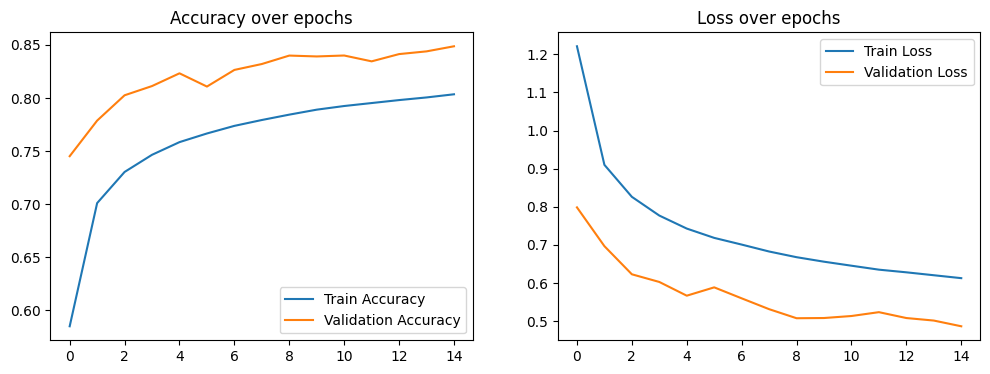

In [ ]:
import matplotlib.pyplot as plt

# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8495 - loss: 0.4866
> 84.874


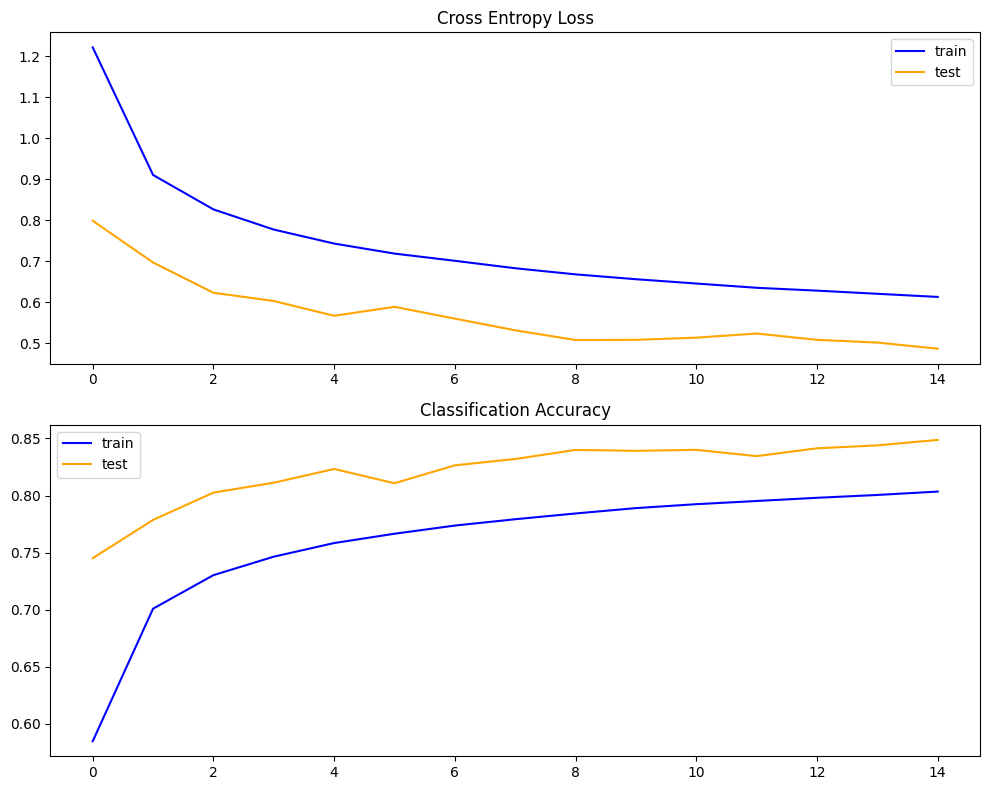

In [ ]:
# Evaluación final
loss, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('> %.3f' % (acc * 100.0))

# Gráficas
plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()

plt.tight_layout()
plt.show()

En las gráficas es puede ver que el módelo parece aprender a un buen rítmo. La curva de perdida parece converger cada vez más, aunque ha medida que aumentaron las épocas, la reducción de la perdida cada vez fue menos. De haber aumentado las épocas la gráfica no hubiera mejorado. Inicialmente entre las primeras 3 épocas es que se tiene la mayor mejora, y esto se puede apreciar tanto en el gráfico de loss como en el de accuracy. A partir de la 4 época los cambios cada vez fueron menores hasta que el modelo pareciera quedarse con un accuracy de alredador del 80%. 

El comportamiento de las gráficas es bastante bueno y la forma de convergencia no muestra overfitting. Por lo que la configuración fue buena para manejar el sobreajuste y el entrenamiento. Comparado con los modelos previos es singificativamene de menor calidad, si comparamos con el accuracy. Por lo que podemos decir con confianza que realmente una red convolucional, debido a las capas y la forma en la que se procesan las imagenes, es un algoritmo más apto para el reconocimiento de imagenes.  



In [ ]:
model.save('mi_modelo_digitos.h5')

# Para el formato .h5
#files.download('mi_modelo_digitos.h5')

model.save('/content/drive/My Drive/mi_modelo.h5')
model.save('/content/drive/My Drive/mi_modelo_digitos.keras')